In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import visualization, preprocess, metrics, naive_autoencoder, analyze_compression, wip_model

2025-05-01 07:06:40.268550: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 07:06:40.300334: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 07:06:40.300350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 07:06:40.300385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 07:06:40.306977: I tensorflow/core/platform/cpu_feature_g

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with GPU support:", tf.test.is_built_with_gpu_support())
print("GPU available:", tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1288947465599675960
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14211350528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11306732471435980516
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
Built with CUDA: True
Built with GPU support: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-05-01 07:06:45.496755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:06:45.536140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:06:45.536171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:06:45.699863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:06:45.699897: I tensorflow/compile

In [13]:
import gc
import tensorflow as tf

# Clear TF session
tf.keras.backend.clear_session()

# Run garbage collection
gc.collect()

4

In [4]:
sequence_length = 4
height = 64
width = 64
channels = 3

In [5]:
import tensorflow as tf
import importlib
importlib.reload(wip_model)

# Define your input shape for the video sequences
input_shape = (sequence_length, height, width, channels)

# Build encoder and decoder
encoder = wip_model.build_encoder(input_shape=input_shape, latent_channels=16)
decoder = wip_model.build_decoder(latent_shape=encoder.output_shape[1:], output_channels=3)

# Vector quantization layer
vq_layer = wip_model.VectorQuantizer(num_embeddings=128, embedding_dim=16)

# Get latent shape without embedding dimension for PixelCNNPrior input
z_index_shape = encoder.output_shape[1:-1]  # (T, H, W)
print("PixelCNN input shape (T, H, W):", z_index_shape)

# Build PixelCNN prior
pixelcnn_prior = wip_model.PixelCNNPrior(input_shape=z_index_shape, num_embeddings=128)

# Compose the full VQ-VAE module
vqvae = wip_model.VQVAEModule(
    encoder=encoder,
    beta_schedule=wip_model.linear_beta_schedule,
    decoder=decoder,
    vq_layer=vq_layer,
    pixelcnn_prior=pixelcnn_prior,
    beta=0.15
)

# Compile with optimizer
vqvae.compile(optimizer= tf.keras.optimizers.AdamW(1e-4, weight_decay=1e-5))
_ = vqvae(tf.random.normal((1, *input_shape)))
vqvae.summary()

2025-05-01 07:07:26.627216: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:07:26.627275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:07:26.627296: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:07:26.627471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 07:07:26.627481: I tensorflow/core/co

PixelCNN input shape (T, H, W): (2, 16, 16)


2025-05-01 07:07:27.333500: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-05-01 07:07:27.410078: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-05-01 07:07:27.410108: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2025-05-01 07:07:27.410156: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-05-01 07:07:27.448506: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:07:27.476407: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_k

Model: "vqvae_module"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Functional)        (None, 2, 16, 16, 16)     6578064   
                                                                 
 Decoder (Functional)        (None, 4, 64, 64, 3)      6578051   
                                                                 
 vector_quantizer (VectorQu  multiple                  2048      
 antizer)                                                        
                                                                 
 pixel_cnn_prior (PixelCNNP  multiple                  0 (unused)
 rior)                                                           
                                                                 
Total params: 16714651 (63.76 MB)
Trainable params: 16714643 (63.76 MB)
Non-trainable params: 8 (32.00 Byte)
_________________________________________________________________


2025-05-01 07:07:27.921835: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [6]:
import numpy as np
import tensorflow as tf

video_folder = "extracted_videos"

# 1. Preprocess the videos
video_data, video_filenames = preprocess.preprocess_videos_with_mapping(
    video_folder=video_folder,
    sequence_length=sequence_length,
    height=height,
    width=width,
    channels=channels
)

# 2. Split into training/validation
split_index = int(0.8 * len(video_data))
train_data = video_data[:split_index]
val_data = video_data[split_index:]

# 3. Reshape to match input shape
train_data = train_data.reshape((-1, sequence_length, height, width, channels)).astype(np.float32)
val_data   = val_data.reshape((-1, sequence_length, height, width, channels)).astype(np.float32)

print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)

# 4. Create dataset objects (no huge memory explosion)
def make_dataset(array, batch_size=4, shuffle=True):
    def generator():
        for x in array:
            yield x
    ds = tf.data.Dataset.from_generator(
        generator,
        output_signature=tf.TensorSpec(shape=(sequence_length, height, width, channels), dtype=tf.float32)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_dataset(train_data, batch_size=4)
val_ds   = make_dataset(val_data, batch_size=4, shuffle=False)


Train data shape: (32141, 4, 64, 64, 3)
Validation data shape: (8036, 4, 64, 64, 3)


In [7]:
import tensorflow as tf

class BetaSchedulerCallback(tf.keras.callbacks.Callback):
    def __init__(self, vqvae_model):
        super().__init__()
        self.vqvae = vqvae_model

    def on_epoch_begin(self, epoch, logs=None):
        if self.vqvae.beta_schedule is not None:
            new_beta = self.vqvae.beta_schedule(epoch)
            self.vqvae.beta.assign(new_beta)
            tf.print("🔁 Beta updated to:", new_beta)


In [7]:
class CodebookUsageLogger(tf.keras.callbacks.Callback):
    def __init__(self, vqvae_model, ds, num_batches=5):
        self.vqvae = vqvae_model
        self.ds = ds
        self.num_batches = num_batches

    def on_epoch_end(self, epoch, logs=None):
        all_indices = []
        for i, x in enumerate(self.ds.take(self.num_batches)):
            out = self.vqvae(x, training=False)
            all_indices.extend(tf.reshape(out["z_indices"], [-1]).numpy())

        used = len(np.unique(all_indices))
        print(f"\n🧩 Codebook usage after epoch {epoch+1}: {used}/{self.vqvae.vq_layer.num_embeddings}")


In [8]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Output directory setup
run_name = "vqvae_mask_video_compression"
output_dir = os.path.join("training_runs", run_name)
os.makedirs(output_dir, exist_ok=True)

# Callbacks
callbacks = [
   # BetaSchedulerCallback(vqvae),
    CodebookUsageLogger(vqvae, val_ds),
    EarlyStopping(monitor="val_loss", patience=40, restore_best_weights=True),
    ModelCheckpoint(
    filepath=os.path.join(output_dir, "epoch_{epoch:02d}.weights.h5"),
    monitor="val_loss",
    save_best_only=False,
    save_weights_only=True
    ),
    TensorBoard(log_dir=os.path.join(output_dir, "logs"))
]

history = vqvae.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40


2025-05-01 07:09:15.935088: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:09:15.935354: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:09:15.935370: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:09:15.935380: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:09:15.935398: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01

   8036/Unknown - 488s 59ms/step - loss: 0.5050 - distortion: 0.1644 - rate: 2.2709 - beta: 0.1500

2025-05-01 07:17:17.437720: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:17:44.577569: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:17:44.578086: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:17:44.578131: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 07:17:44.578673: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01


🧩 Codebook usage after epoch 1: 48/128
8036/8036 [==============================] - 519s 63ms/step - loss: 0.5050 - distortion: 0.1644 - rate: 2.2709 - beta: 0.1500 - val_loss: 0.5549 - val_distortion: 0.2169 - val_rate: 2.2536
Epoch 2/40
8036/8036 [==============================] - ETA: 0s - loss: 0.4412 - distortion: 0.1190 - rate: 2.1482 - beta: 0.1500
🧩 Codebook usage after epoch 2: 59/128
8036/8036 [==============================] - 512s 64ms/step - loss: 0.4412 - distortion: 0.1190 - rate: 2.1482 - beta: 0.1500 - val_loss: 0.5545 - val_distortion: 0.2132 - val_rate: 2.2753
Epoch 3/40
8036/8036 [==============================] - ETA: 0s - loss: 0.4114 - distortion: 0.1043 - rate: 2.0477 - beta: 0.1500
🧩 Codebook usage after epoch 3: 63/128
8036/8036 [==============================] - 512s 64ms/step - loss: 0.4114 - distortion: 0.1043 - rate: 2.0477 - beta: 0.1500 - val_loss: 0.5605 - val_distortion: 0.2234 - val_rate: 2.2477
Epoch 4/40
8035/8036 [============================>.] -

In [16]:
import os

# Path to saved weights from epoch 6
weights_path = os.path.join(
    "training_runs", 
    "vqvae_nova_video_compression", 
    "epoch_20.weights.h5"
)

# Load into your VQ-VAE model
vqvae.load_weights(weights_path)
print("✓ Weights loaded from:", weights_path)

✓ Weights loaded from: training_runs/vqvae_nova_video_compression/epoch_20.weights.h5


In [17]:
metrics_val = metrics.evaluate_metrics_by_video(
    split="val",
    limit=5,
    video_data=video_data,
    video_filenames=video_filenames,
    autoencoder=vqvae,
    sequence_length=sequence_length,
    height=height,
    width=width
)
metrics_val

109/109 [==============================] - 1s 7ms/step
📹 Evaluating: celebv_-eDeQp6hees_1.mp4 — 109 sequences
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


2025-05-01 01:39:38.941990: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 01:39:38.942117: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 01:39:38.942156: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 01:39:38.942193: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01 01:39:38.942233: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-05-01

152/152 [==============================] - 1s 6ms/step
📹 Evaluating: celebv_-_Bdf9C0SAU_2.mp4 — 152 sequences
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
99/99 [==============================] - 1s 6ms/step
📹 Evaluating: celebv_-Z1lkcEEF_w_2.mp4 — 99 sequences
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
276/276 [==============================] - 2s 7ms/step
📹 Evaluating: celebv_-edZKfoS2V4_3.mp4 — 276 sequences
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
71/71 [==============================] - 0s 7ms/step
📹 Evaluating: celebv_-a-SZLSDFWk_3.mp4 — 71 sequences
Setting 

{'celebv_-eDeQp6hees_1.mp4': {'psnr': 27.819674,
  'ssim': 0.87506837,
  'lpips': 0.11237819186932997},
 'celebv_-_Bdf9C0SAU_2.mp4': {'psnr': 28.902382,
  'ssim': 0.8461946,
  'lpips': 0.07466398294108283},
 'celebv_-Z1lkcEEF_w_2.mp4': {'psnr': 33.410316,
  'ssim': 0.8946481,
  'lpips': 0.054629824641678065},
 'celebv_-edZKfoS2V4_3.mp4': {'psnr': 24.103785,
  'ssim': 0.75526816,
  'lpips': 0.1822023667746048},
 'celebv_-a-SZLSDFWk_3.mp4': {'psnr': 21.47166,
  'ssim': 0.7477452,
  'lpips': 0.09840245969908339}}

In [ ]:
import json
import numpy as np

def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    return obj

metrics_val_converted = convert_numpy(metrics_val)

with open("vqvae_train_metrics.json", "w") as f:
    json.dump(metrics_val_converted, f, indent=4)


In [16]:
import json
import numpy as np

# Load JSON files
with open("vqvae_train_metrics.json", "r") as f:
    train_metrics = json.load(f)

with open("vqvae_val_metrics.json", "r") as f:
    val_metrics = json.load(f)

# Helper to average metrics over videos
def average_metrics(metric_dict):
    psnr_vals = [v["psnr"] for v in metric_dict.values()]
    ssim_vals = [v["ssim"] for v in metric_dict.values()]
    lpips_vals = [v["lpips"] for v in metric_dict.values()]
    
    return {
        "psnr": np.mean(psnr_vals),
        "ssim": np.mean(ssim_vals),
        "lpips": np.mean(lpips_vals)
    }

# Compute averages
avg_train = average_metrics(train_metrics)
avg_val = average_metrics(val_metrics)

# Print comparison
print("📊 Average Metrics Comparison")
print(f"Train - PSNR: {avg_train['psnr']:.2f}, SSIM: {avg_train['ssim']:.4f}, LPIPS: {avg_train['lpips']:.4f}")
print(f"Val   - PSNR: {avg_val['psnr']:.2f}, SSIM: {avg_val['ssim']:.4f}, LPIPS: {avg_val['lpips']:.4f}")


📊 Average Metrics Comparison
Train - PSNR: 23.92, SSIM: 0.8165, LPIPS: 0.1077
Val   - PSNR: 24.29, SSIM: 0.7925, LPIPS: 0.1303


In [ ]:
import metrics
importlib.reload(metrics)
video_name = "celebv_-bDW55dxoCg_0.mp4"

metrics = metrics.evaluate_single_video_metrics(
    video_name=video_name,
    video_data=video_data,
    video_filenames=video_filenames,
    autoencoder=vqvae,
    sequence_length=sequence_length,
    height=height,
    width=width,
    channels=channels
)

print(f"📊 Metrics for {video_name}:\n", metrics)


107/107 [==============================] - 1s 6ms/step
🎞️ Evaluating metrics for: celebv_-bDW55dxoCg_0.mp4 — 107 sequences
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/nchanak/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
📊 Metrics for celebv_-bDW55dxoCg_0.mp4:
 {'psnr': 29.500128, 'ssim': 0.8268457, 'lpips': 0.10635009477628726}


In [9]:
import importlib
import analyze_compression

importlib.reload(analyze_compression)
with tf.device('/CPU:0'):
    compression_results = analyze_compression.evaluate_compression_by_video(
        split="val",
        limit=3,
        video_data=video_data,
        video_filenames=video_filenames,
        autoencoder=vqvae,
        encoder=encoder,
        sequence_length=sequence_length,
        height=height,
        width=width
    )
compression_results

Evaluating compression on 3 val videos...

217/217 [==============================] - 6s 26ms/step


{'celebv_-a_GdyL1yHo_1_0.mp4': {'video': 'celebv_-a_GdyL1yHo_1_0.mp4',
  'num_sequences': 669,
  'num_frames': 2676,
  'input_kb_estimated': 30269.11749241926,
  'codec_kb': 1384.8486328125,
  'latent_kb_raw': 334.5,
  'latent_kb_estimated': 142.6277618408203,
  'compression_ratio_codec': 21.85734727624742,
  'compression_ratio_latent': 212.2245844830763,
  'vq_time_secs': 19.848833799362183},
 'celebv_-a-SZLSDFWk_7.mp4': {'video': 'celebv_-a-SZLSDFWk_7.mp4',
  'num_sequences': 138,
  'num_frames': 552,
  'input_kb_estimated': 6169.8382917643,
  'codec_kb': 226.6650390625,
  'latent_kb_raw': 69.0,
  'latent_kb_estimated': 28.62725067138672,
  'compression_ratio_codec': 27.220070273223943,
  'compression_ratio_latent': 215.5232565847173,
  'vq_time_secs': 4.0452117919921875},
 'celebv_-bQLjUP0eRc_30_0.mp4': {'video': 'celebv_-bQLjUP0eRc_30_0.mp4',
  'num_sequences': 217,
  'num_frames': 868,
  'input_kb_estimated': 9929.276954312934,
  'codec_kb': 360.203125,
  'latent_kb_raw': 108.5,
 

In [20]:
play_video = "celebv_-bDW55dxoCg_0.mp4"

visualization.generate_and_display_comparison(
    video_name=play_video,
    autoencoder=vqvae,
    sequence_length=sequence_length,
    height=height,
    width=width,
    cleanup=True 
)

4/4 [==============================] - 0s 105ms/step
[✓] Comparison saved: comparison_celebv_-bDW55dxoCg_0.avi
[▶] Converting comparison_celebv_-bDW55dxoCg_0.avi → comparisons/comparison_celebv_-bDW55dxoCg_0.mp4
Deleted: comparison_celebv_-bDW55dxoCg_0.avi


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [22]:
import aac
import importlib
importlib.reload(aac)

val_filenames = video_filenames[split_index:]
video_name = "celebv_-bDW55dxoCg_0.mp4"

results = aac.analyze_with_aac(
    video_name=video_name,
    encoder=encoder,
    decoder=decoder,
    vq_layer=vq_layer,
    pixelcnn_prior=pixelcnn_prior,
    sequence_length=sequence_length,
    height=height,
    width=width
)

107/107 [==============================] - 0s 3ms/step
z_q size (bytes): 3506176
4/4 [==============================] - 0s 21ms/step


In [23]:
print(f"\n📝 AAC Compression Results for: {results['video']}\n")
print(f"  • Number of sequences:     {results['num_sequences']}")
print(f"  • Total bytes (AAC):        {results['bytes_aac']:.2f} bytes")
print(f"  • Total size (AAC):         {results['kb_aac']:.2f} KB")
print(f"  • Compression ratio (AAC):  {results['compression_ratio_aac']:.2f}x")
print(f"  • Reconstruction shape:     {results['reconstruction'].shape}")
print("\n✅ Done!\n")


📝 AAC Compression Results for: celebv_-bDW55dxoCg_0.mp4

  • Number of sequences:     107
  • Total bytes (AAC):        129540.00 bytes
  • Total size (AAC):         126.50 KB
  • Compression ratio (AAC):  170286799.69x
  • Reconstruction shape:     (107, 4, 64, 64, 3)

✅ Done!



Compute ssim of h264

In [54]:
import os
import cv2
import numpy as np
import tensorflow as tf

def compute_h264_ssim_comparison(video_name, height=64, width=64, crf=23, cleanup=True):
    """
    Computes SSIM between original and H.264-compressed version of a video after resizing both to (height x width).
    """

    # Paths
    input_path = os.path.join("extracted_videos", video_name)
    resized_path = f"temp_resized_{video_name}"
    compressed_path = f"temp_compressed_{video_name}"

    # Step 1: Resize + Compress to H.264
    resize_compress_cmd = (
        f'ffmpeg -y -i "{input_path}" -vf scale={width}:{height} '
        f'-c:v libx264 -crf {crf} -preset medium "{compressed_path}"'
    )
    os.system(resize_compress_cmd)

    # Step 2: Extract original resized frames (using OpenCV resize for accurate baseline)
    cap_orig = cv2.VideoCapture(input_path)
    orig_frames = []
    while True:
        ret, frame = cap_orig.read()
        if not ret:
            break
        resized = cv2.resize(frame, (width, height))
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
        orig_frames.append(rgb)
    cap_orig.release()
    orig_frames = np.array(orig_frames)

    # Step 3: Extract H.264-compressed frames
    cap_comp = cv2.VideoCapture(compressed_path)
    comp_frames = []
    while True:
        ret, frame = cap_comp.read()
        if not ret:
            break
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        comp_frames.append(rgb)
    cap_comp.release()
    comp_frames = np.array(comp_frames)

    # Step 4: Match frame lengths
    n = min(len(orig_frames), len(comp_frames))
    orig_frames = orig_frames[:n]
    comp_frames = comp_frames[:n]

    # Step 5: Compute SSIM
    ssim_scores = []
    for o, c in zip(orig_frames, comp_frames):
        o_tf = tf.convert_to_tensor(o[np.newaxis].astype(np.float32))
        c_tf = tf.convert_to_tensor(c[np.newaxis].astype(np.float32))
        score = tf.image.ssim(o_tf, c_tf, max_val=255.0).numpy()[0]
        ssim_scores.append(score)

    mean_ssim = np.mean(ssim_scores)
    print(f"📉 Mean SSIM (H.264 vs original @ {width}x{height}): {mean_ssim:.4f}")

    # Step 6: Cleanup temp files
    if cleanup:
        for path in [resized_path, compressed_path]:
            try:
                os.remove(path)
            except Exception:
                pass

    return mean_ssim

compute_h264_ssim_comparison("celebv_-bDW55dxoCg_0.mp4", height=64, width=64)

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

📉 Mean SSIM (H.264 vs original @ 64x64): 0.9558


0.9558126

In [24]:
importlib.reload(aac)

aac.generate_and_display_aac_comparison(
    video_name=video_name,
    aac_results_dict=results,
    height=64,
    width=64,
    video_folder="extracted_videos",
)

[✓] Side-by-side AAC comparison saved to: comparison_aac_celebv_-bDW55dxoCg_0.avi
[▶] Converting comparison_aac_celebv_-bDW55dxoCg_0.avi → comparisons/comparison_aac_celebv_-bDW55dxoCg_0.mp4
Deleted temporary file: comparison_aac_celebv_-bDW55dxoCg_0.avi


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [23]:
importlib.reload(aac)

aac.save_aac_reconstruction_only(
    aac_results_dict=results,
    video_name=video_name,
    out_dir="reconstructions",
    fps=24,
    scale=4
)

[✓] Saved reconstructed AAC video to: reconstructions/celebv_-bDW55dxoCg_0_recon.mp4


In [35]:
importlib.reload(aac)

aac.generate_and_display_aac_comparison_avi(
    video_name=video_name,
    aac_results_dict=results,
    height=64,
    width=64,
    video_folder="extracted_videos",
    out_dir="comparisons",
    fps=24,
    scale=4
)


Recon frames shape: (108, 64, 64, 3)
[✓] Saved side-by-side comparison AVI to: comparisons/comparison_aac_celebv_-bDW55dxoCg_0.avi


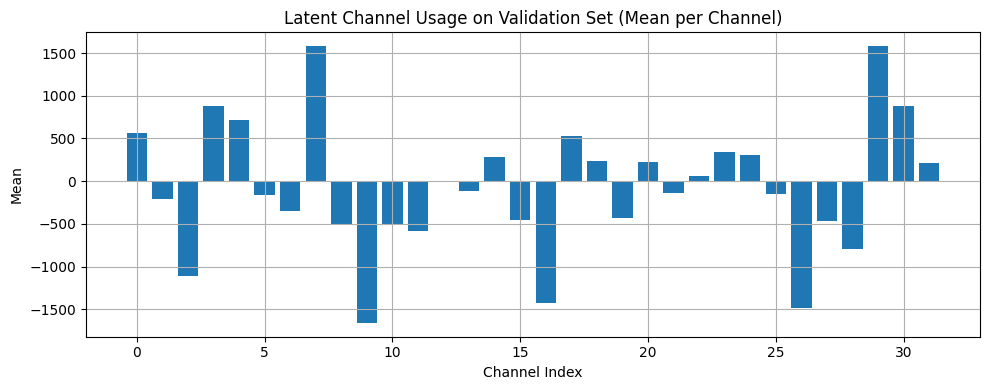

In [41]:
# Helper functions
def extract_normalized_frames(video_path, height, width):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_resized = cv2.resize(frame, (width, height))
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb / 255.0)
    cap.release()
    return np.array(frames)

def create_sequences(frames, sequence_length):
    return np.array([frames[i:i+sequence_length] for i in range(len(frames) - sequence_length + 1)])

# Load video filenames (assumed available from user context)
video_filenames_val = sorted(set(video_filenames[split_index:]))

# Collect all latents
all_z_flat = []

for video_name in video_filenames_val:
    video_path = os.path.join(video_folder, video_name)
    frames = extract_normalized_frames(video_path, height, width)
    sequences = create_sequences(frames, sequence_length)
    if sequences.shape[0] == 0:
        continue
    z = vqvae.encoder(sequences, training=False).numpy()  # (N, T, H, W, C)
    z_flat = z.reshape(-1, z.shape[-1])  # (N*T*H*W, C)
    all_z_flat.append(z_flat)

# Stack all flattened latents
z_all = np.vstack(all_z_flat)

# Compute stats
mean_per_channel = np.mean(z_all, axis=0)
std_per_channel = np.std(z_all, axis=0)

# Plot
plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(mean_per_channel)), mean_per_channel)
plt.title("Latent Channel Usage on Validation Set (Mean per Channel)")
plt.xlabel("Channel Index")
plt.ylabel("Mean")
plt.grid(True)
plt.tight_layout()
plt.show()

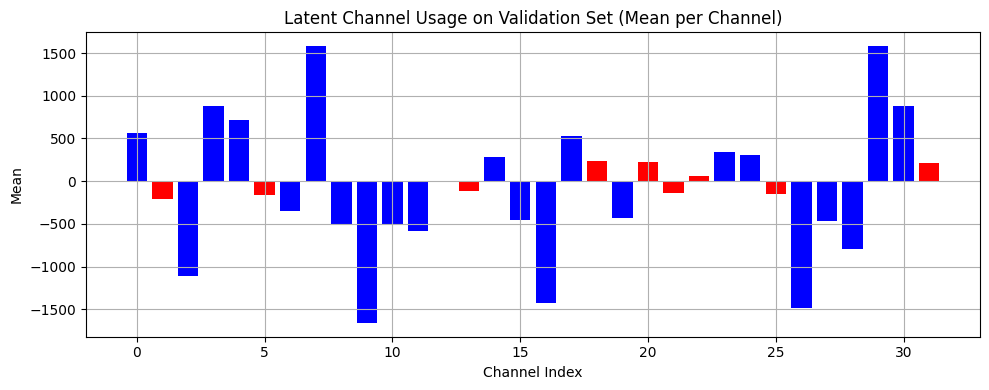

In [45]:
abs_means = np.abs(mean_per_channel)
threshold = 0.15 * np.max(np.abs(mean_per_channel))

colors = ['red' if abs(m) < threshold else 'blue' for m in mean_per_channel]

plt.figure(figsize=(10, 4))
plt.bar(np.arange(len(mean_per_channel)), mean_per_channel, color=colors)
plt.title("Latent Channel Usage on Validation Set (Mean per Channel)")
plt.xlabel("Channel Index")
plt.ylabel("Mean")
plt.grid(True)
plt.tight_layout()
plt.show()